In [2]:
import seaborn as sns
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import seaborn as sns
from IPython.display import Image, display


sns.set_style("white")
sns.set_palette("husl")

class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?(_epoch\d+)?")

    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.epoch = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_epoch = groups[8]
            self.epoch = int(unparsed_epoch.strip("_epoch"))


    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, top_{}/{}, lr={}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, {}, lr={}".format(self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr)                                               
        if self.trial:
            label += ", trial-{}".format(self.trial)
        if self.epoch:
            label += ", epoch-{}".format(self.epoch)
        return label

def write_file(plot_file_prefix):
    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    plt.clf()

In [3]:
def plot_image_distributions(pickles_dir, plot_dir, trials=None):
    print("In plot_image_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            n, bins, patches = plt.hist(d.values(),
                                        50,
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            
            plt.title(config.label)

            plt.xlim(0, max(d.values()) + 1)
            plt.xlabel("Num backprops")
            plt.ylabel("Num images")

            subplot_dir = os.path.join(plot_dir, "images_dist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix)


In [4]:
def analyze_stdev(stdev_by_image_id, filename, src_dir="../data/images/cifar10_by_id", top_k=10):
    config = Config(filename)
    print("Analyzing stdevs for {}".format(config.label))
    stdevs = stdev_by_image_id.values()
    n, bins, patches = plt.hist(stdevs,
                                10,
                                normed=0,
                                alpha=0.8)            
    plt.title(config.label)
    plt.xlabel("Probability stdev")
    plt.ylabel("Frequency")

    subplot_dir = os.path.join(plot_dir, "probabilities_by_image")
    if not os.path.isdir(subplot_dir):
        os.mkdir(subplot_dir)
    plt.tight_layout()
    plot_prefix = os.path.join(subplot_dir, filename + "_stdev")
    write_file(plot_prefix)

    sorted_ids = sorted(stdev_by_image_id, key=lambda k: stdev_by_image_id[k])
    
    # Show image_ids with highest stdev
    print("Images from sample with highest stdev")
    for image_id in list(reversed(sorted_ids))[:top_k]:
        src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
        display(Image(filename=src_file))

    # Show image_ids with lowest stdev
    print("Images from sample with lowest stdev")
    for image_id in sorted_ids[:top_k]:
        src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
        display(Image(filename=src_file))
              

In [15]:
def plot_probability_timelines(pickles_dir, plot_dir, max_ids=None, trials=None):
    print("In plot_probability_timelines for {}".format(plot_dir))
    palette = itertools.cycle(sns.color_palette())

    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            stdev_by_image_id = {}
            for image_id, ys in d.iteritems():
                xs = range(len(ys))
                stdev_by_image_id[image_id] = np.std(ys)
                if max_ids <= image_id:
                    break
                plt.plot(xs, ys, color=next(palette))
            plt.title(config.label)
            plt.xlabel("Epochs")
            plt.ylabel("Select Probability")

            subplot_dir = os.path.join(plot_dir, "probabilities_by_image")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plot_prefix = os.path.join(subplot_dir, filename)
            plt.tight_layout()
            write_file(plot_prefix)
            
           # analyze_standard_deviations
            analyze_stdev(stdev_by_image_id, filename)

In [6]:
def plot_confidence_distributions(pickles_dir, plot_dir, max_epoch=None, trials=None):
    print("In plot_confidence_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            print(pickles_file)
            d = pickle.load(handle)
            for epoch, data in d.iteritems():
                if max_epoch is not None:
                    if epoch > max_epoch:
                        break
                probs = data["confidences"]
                num_backpropped = data["num_backpropped"]
                n, bins, patches = plt.hist(probs,
                                            50,
                                            normed=0,
                                            facecolor='green',
                                            alpha=0.75)
                plt.title("{}, {} backpropped".format(config.label, num_backpropped))

                plt.xlabel("Probability of target")
                plt.ylabel("Frequency")

                subplot_dir = os.path.join(plot_dir, "target_confidences")
                if not os.path.isdir(subplot_dir):
                    os.mkdir(subplot_dir)
                plot_prefix = os.path.join(subplot_dir, "{}_epoch{}_{}backpropped".format(filename,
                                                                              epoch,
                                                                              num_backpropped))
                plt.tight_layout()
                write_file(plot_prefix)
                


In [12]:
def plot_experiment(experiment_dir,
                    plot_dir,
                    max_ids=0,
                    run_image_id_hist = False,
                    run_target_confidences = True,
                    run_probability_timelines = True,
                    trials=None):
    pickles_dir = os.path.join(experiment_dir, "pickles")
    if os.path.isdir(pickles_dir):
        if run_probability_timelines:
            probabilities_dir = os.path.join(pickles_dir, "probabilities_by_image")
            if os.path.isdir(probabilities_dir):
                plot_probability_timelines(probabilities_dir,
                                           plot_dir,
                                           max_ids=max_ids,
                                           trials=trials)
        if run_target_confidences:
            target_confidences_dir = os.path.join(pickles_dir, "target_confidences")
            if os.path.isdir(target_confidences_dir):
                plot_confidence_distributions(target_confidences_dir, plot_dir, trials=trials)
        if run_image_id_hist:
            image_id_hist_dir = os.path.join(pickles_dir, "image_id_hist")
            if os.path.isdir(image_id_hist_dir):
                plot_image_distributions(image_id_hist_dir, plot_dir, trials=trials)
            

%matplotlib inline

In plot_probability_timelines for ../plots/batch_stats/181014_refactor/181014_square


KeyboardInterrupt: 

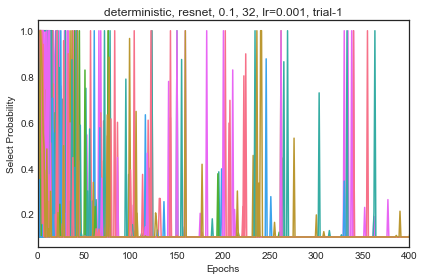

In [13]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181014_refactor"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181014_square", "181014_baseline_recenter"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir,
                    plot_dir,
                    max_ids=50,
                    run_target_confidences=False,
                    trials=[1])


In plot_probability_timelines for ../plots/batch_stats/181016_notransform/181016_notransform_square
Analyzing stdevs for deterministic, resnet, 0.1, 32, lr=0.001, trial-1
Images from sample with highest stdev


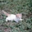

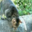

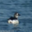

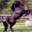

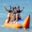

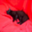

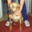

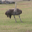

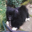

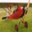

Images from sample with lowest stdev


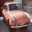

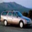

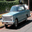

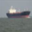

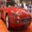

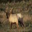

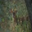

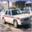

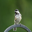

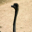

<Figure size 432x288 with 0 Axes>

In [315]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181016_notransform"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181016_notransform_square"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir, plot_dir, max_ids=100,
                    trials=[1])

In plot_probability_timelines for ../plots/batch_stats/181019_mnist/181019_mnist_square
Analyzing stdevs for sampling, lecunn, 0.1, 32, lr=0.001, trial-1
Images from sample with highest stdev


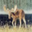

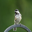

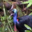

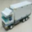

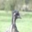

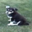

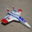

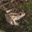

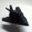

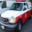

Images from sample with lowest stdev


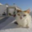

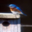

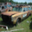

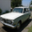

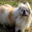

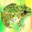

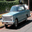

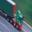

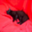

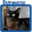

Analyzing stdevs for sampling, lecunn, 0.2, 32, lr=0.001, trial-1
Images from sample with highest stdev


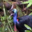

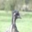

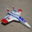

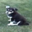

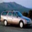

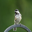

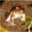

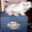

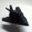

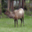

Images from sample with lowest stdev


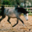

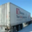

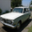

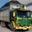

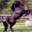

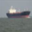

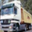

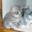

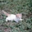

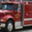

Analyzing stdevs for sampling, lecunn, 0.4, 32, lr=0.001, trial-1
Images from sample with highest stdev


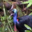

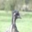

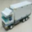

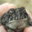

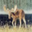

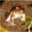

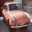

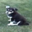

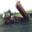

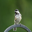

Images from sample with lowest stdev


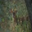

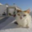

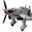

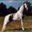

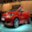

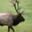

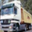

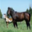

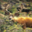

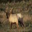

Analyzing stdevs for sampling, lecunn, 0.6, 32, lr=0.001, trial-1
Images from sample with highest stdev


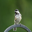

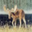

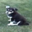

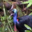

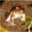

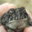

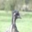

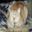

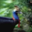

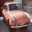

Images from sample with lowest stdev


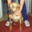

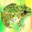

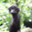

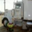

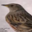

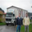

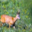

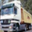

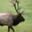

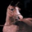

Analyzing stdevs for sampling, lecunn, 1.0, 32, lr=0.001, trial-1
Images from sample with highest stdev


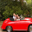

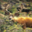

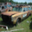

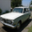

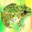

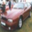

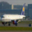

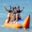

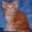

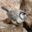

Images from sample with lowest stdev


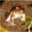

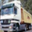

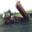

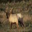

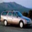

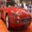

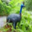

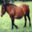

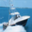

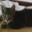

In plot_confidence_distributions for ../plots/batch_stats/181019_mnist/181019_mnist_square
../data/output/mnist/181019_mnist_square/pickles/target_confidences/sampling_mnist_lecunn_.1_32_0.001_0.0005_trial1_target_confidences.pickle


KeyboardInterrupt: 

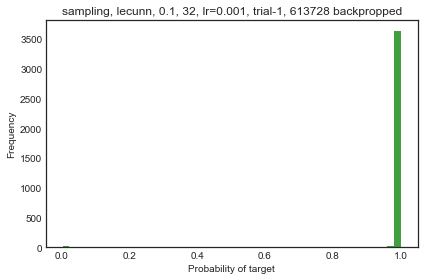

In [16]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181019_mnist"
plot_home_dir += "/{}".format(experiment_batch_name)
if not os.path.exists(plot_home_dir):
    os.makedirs(plot_home_dir)

experiment_names = ["181019_mnist_square"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/mnist/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir, plot_dir, max_ids=100,
                    trials=[1])